In [1]:
from plotting import *
from matplotlib import pyplot as plt

from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense
from keras.models import Model

import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
mat_contents = sio.loadmat('DRIVEdata.mat')
x = mat_contents['DataMatrix']
y = mat_contents['Labels']

# Replace value in y: [0 1] -> 1 and [1 0] -> 2
y = y[:,0]
y = np.where(y == 1, 2, 1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')

(32000, 625) train samples
(8000, 625) test samples


In [3]:
# Normalize features
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train.shape,X_test.shape

((32000, 625), (8000, 625))

**1. Autoencode the Data with 50 hidden units selecting a decent learning rate for
convergence.**

In [4]:
def create_autoencoder(num_features, encoding_dim=50, learning_rate=0.01):
    input_img = Input(shape=(num_features,))
    encoded = Dense(encoding_dim, activation='sigmoid')(input_img)
    decoded = Dense(num_features, activation='sigmoid')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    decoder_layer = autoencoder.layers[-1]
    
    encoded_input = Input(shape=(encoding_dim,))
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

    optimizer_adam = Adam(lr=learning_rate)
    autoencoder.compile(optimizer=optimizer_adam, loss='binary_crossentropy')
    
#     optimizer_SGD = SGD(lr=learning_rate, momentum=0.25)
#     autoencoder.compile(optimizer=optimizer_SGD, loss='binary_crossentropy')
    
    return encoder, decoder, autoencoder

In [5]:
# Settings for Autoencoder
nb_epoch = 3
learning_rate = 0.001 # recommended default for adam in keras
num_features = X_train.shape[1]

In [6]:
encoding_dim = 50  

encoder, decoder, autoencoder = create_autoencoder(num_features, encoding_dim, learning_rate)

AE_50 = autoencoder.fit(X_train, X_train,
                nb_epoch=nb_epoch,
                shuffle=True,
                validation_data=(X_train, X_train))

Train on 32000 samples, validate on 32000 samples
Epoch 1/10
32000/32000 [==============================] - 5s - loss: 0.6726 - val_loss: 0.6651
Epoch 2/10
32000/32000 [==============================] - 5s - loss: 0.6616 - val_loss: 0.6600
Epoch 3/10
32000/32000 [==============================] - 6s - loss: 0.6588 - val_loss: 0.6579
Epoch 4/10
32000/32000 [==============================] - 6s - loss: 0.6576 - val_loss: 0.6578
Epoch 5/10
32000/32000 [==============================] - 5s - loss: 0.6570 - val_loss: 0.6566
Epoch 6/10
32000/32000 [==============================] - 6s - loss: 0.6565 - val_loss: 0.6562
Epoch 7/10
32000/32000 [==============================] - 6s - loss: 0.6561 - val_loss: 0.6558
Epoch 8/10
32000/32000 [==============================] - 6s - loss: 0.6558 - val_loss: 0.6556
Epoch 9/10
32000/32000 [==============================] - 6s - loss: 0.6555 - val_loss: 0.6556
Epoch 10/10
32000/32000 [==============================] - 6s - loss: 0.6554 - val_loss: 0.6552

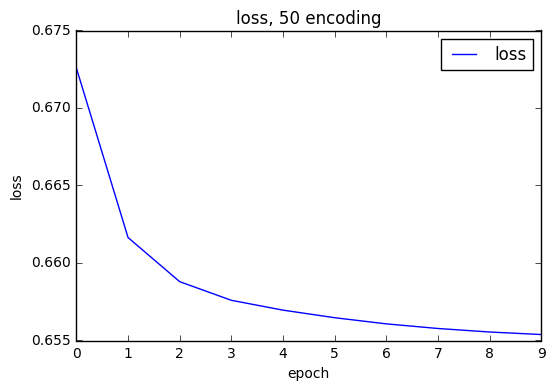

In [7]:
plot_loss(models=[AE_50], legend=['loss'], title='loss, 50 encoding')

**2. Use the 50 dimensional learnt features to train a Random Forest and a Logistic
Regression Classifier (Use any inbuilt or open source code for Random Forest
and Logistic Regression).**


In [8]:
#decoded_imgs = decoder.predict(encoded_imgs)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Classfier 1: Train random forest classifier with 20 trees and max depth of 4. (Encoded data)
clf_randomforest = RandomForestClassifier(n_estimators=20, max_depth=4)
clf_randomforest.fit(X_train_encoded, y_train)
y_pred = clf_randomforest.predict(X_test_encoded)

cnf_matrix_encode_randomforest = confusion_matrix(y_test, y_pred)

# Classfier 2: Train random forest classifier with 20 trees and max depth of 4. (Normal)
clf_randomforest = RandomForestClassifier(n_estimators=20, max_depth=4)
clf_randomforest.fit(X_train, y_train)
y_pred = clf_randomforest.predict(X_test)

cnf_matrix_normal_randomforest = confusion_matrix(y_test, y_pred)


In [10]:
from sklearn import linear_model


# Classfier 3: Train logistic regression classifier (Encoded data)
clf_logreg = linear_model.LogisticRegression()
clf_logreg.fit(X_train_encoded, y_train)
y_pred = clf_logreg.predict(X_test_encoded)

cnf_matrix_encode_logreg = confusion_matrix(y_test, y_pred)

# Classfier 4: Train logistic regression classifier  (Normal)
clf_logreg = linear_model.LogisticRegression()
clf_logreg.fit(X_train, y_train)
y_pred = clf_logreg.predict(X_test)

cnf_matrix_normal_logreg = confusion_matrix(y_test, y_pred)


**3. Compare their performance on the 20% testing data and report them.**

In [11]:
class_names = np.unique(y)

plot_confusion_matrix_performance(cnf_matrix=cnf_matrix_encode_randomforest, classes=class_names,model_name="Random Forest (Encoded)")
plot_confusion_matrix_performance(cnf_matrix=cnf_matrix_normal_randomforest, classes=class_names,model_name="Random Forest Normal")

plot_confusion_matrix_performance(cnf_matrix=cnf_matrix_encode_logreg, classes=class_names,model_name="Log Reg (Encoded)")
plot_confusion_matrix_performance(cnf_matrix=cnf_matrix_normal_logreg, classes=class_names,model_name="Log Reg Normal")

NameError: name 'np' is not defined

**4. Visualize the learnt weights.**

In [ ]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(25, 25))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(25, 25))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()